<a href="https://colab.research.google.com/github/Mohamad-Atif1/paper2code/blob/main/Transformers/SETR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This** notebook is made by **Eng. Mohammed Alshabrawi**

**Rethinking Semantic Segmentation from a Sequence-to-Sequence Perspective**

**Image semantic segmentation** assigns a class label to every pixel in an image. It was mainly done using CNNs (Encoder-Decoder) for capturing local patterns. Now, transformer-based models like SETR [Rethinking Semantic Segmentation from a Sequence-to-Sequence Perspective](https://arxiv.org/abs/2012.15840) are used to better capture global context and improve results.

SETR is one of the first models to use Transformers for image segmentation. Many other models came after SETR using transformers for this task, but I think implementing SETR is a good start to understand the others more easily.



<img src="https://miro.medium.com/v2/resize:fit:930/1*PTJG8xXcD701EjSzS8mfbA.png" >

The model is an Encoder-Decoder model. The Encoder extract global features from the images through Vision Transforemr ([check out the previous notebook](https://github.com/Mohamad-Atif1/paper2code/blob/main/Transformers/ViT.ipynb)). The Decoder performs upsampling to match the original image dimensions.

# ViT

[VIT](https://github.com/Mohamad-Atif1/paper2code/blob/main/Transformers/ViT.ipynb)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self,img_size,patch_size,embed_size,in_channels):
        super(PatchEmbedding,self).__init__()
        self.embed_size = embed_size
        # number of patches = (Height * Width) / (patch_height * patch_width)
        # in the orginal paper, images and patches are square (Height = Width), so
        # number of patches = (Highet^2) / (patch_height^2) = (Highet / patch_height) ^2
        self.n_patches = (img_size // patch_size) ** 2
        assert img_size % patch_size == 0, f"Image size {img_size} must be divisible by patch size {patch_size}"

        # Extracting "embed_size" features of each patch seperatelly using Conv2d
        # In the paper it is named " Linear Projection of Flattend Patches"
        self.projection = nn.Conv2d(in_channels,embed_size,patch_size,patch_size)

    def forward(self,img):
        img = self.projection(img) # Now we have n features for each patch, n = embed_size
        img = img.reshape(-1,self.n_patches,self.embed_size) # bs, seq_len, embed_size
        return img

In [ ]:
class ViT(nn.Module):
    def __init__(
            self,
            img_size,
            patch_size,
            embed_size,
            in_channels,
            num_heads,
            num_layers,
            ff_expansion,
            dout,
            ):
        super(ViT,self).__init__()

        self.n_patches = (img_size // patch_size) ** 2 # HW/P^2
        assert img_size % patch_size == 0, f"Image size {img_size} must be divisible by patch size {patch_size}"

        self.pos_embed = nn.Parameter(torch.randn(1, self.n_patches , embed_size))
        self.cls = nn.Parameter(torch.randn(1,1,embed_size))
        self.patch_embed = PatchEmbedding(img_size,patch_size,embed_size,in_channels)
        encoder_layer = nn.TransformerEncoderLayer(
                    d_model=embed_size,
                    nhead=num_heads,
                    dim_feedforward=int(embed_size * ff_expansion),
                    dropout=dout,
                    activation='gelu', # They used gelu in ViT paper
                    batch_first=True,
                    norm_first=True  # pre-norm architecture like ViT paper
                )
        self.encoder = nn.TransformerEncoder(encoder_layer,num_layers)


    def forward(self,img):
        img = self.patch_embed(img)

        # You can expand the pos_embed to match batch size, but
        # pytorch do it automatically when only one dimension is different
        img = img + self.pos_embed # this broadcasting automatically

        # Now we are ready to pass these patches to the Encoder
        img = self.encoder(img)

        return img


# Decoder

n the original paper, the authors designed two different decoder variants: progressive upsampling (SETR-PUP) and multi-level feature aggregation (SETR-MLA). Both perform upsampling but use different architectural designs.

Here, I implemented SETR-PUP, which mainly relies on two operations: convolution and upsampling. For upsampling, it uses bilinear interpolation to scale the feature maps by 2×. You can see this video for more on [bilnear image scaling](https://youtu.be/AqscP7rc8_M?feature=shared)
<img src="https://github.com/Mohamad-Atif1/paper2code/blob/main/Transformers/images/SETR_DECODER.png?raw=true" >

The design is fairly straightforward. First, the embedding is reshaped from 2D (n_patches × embed_size) to 3D (C, H, W). This is followed by four blocks of Conv2D and upsampling layers.

Note: the number 19 in the final output is the number of classes



In [ ]:
class Decoder(nn.Module):
    def __init__(self,embed_size,conv_channels,num_classes):
        super(Decoder, self).__init__()
        self.num_classes = num_classes
        self.upsampling = nn.UpsamplingBilinear2d(scale_factor=2)
        self.conv1 = nn.Conv2d(embed_size,conv_channels,3,1,1)
        self.conv2 = nn.Conv2d(conv_channels,conv_channels,3,1,1)
        self.conv3 = nn.Conv2d(conv_channels,conv_channels,3,1,1)
        self.conv4 = nn.Conv2d(conv_channels,num_classes,3,1,1)
        self.relu = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm2d(conv_channels)
        self.batchnorm2 = nn.BatchNorm2d(conv_channels)
        self.batchnorm3 = nn.BatchNorm2d(conv_channels)

    def forward(self,x):
        x = self.relu(self.batchnorm1(self.conv1(x)))
        x = self.upsampling(x)
        x = self.relu(self.batchnorm2(self.conv2(x)))
        x = self.upsampling(x)
        x = self.relu(self.batchnorm3(self.conv3(x)))
        x = self.upsampling(x)
        x = self.conv4(x)
        x = self.upsampling(x)
        return x



In [ ]:
class SETR(nn.Module):
    def __init__(self,img_size,patch_size,embed_size,conv_channels,num_classes,
                 in_channels,num_heads,num_layers,ff_expansion,vit_dout):
        super(SETR, self).__init__()
        self.vit = ViT(img_size,patch_size,embed_size,in_channels,num_heads,num_layers,ff_expansion,vit_dout)
        self.decoder = Decoder(embed_size,conv_channels,num_classes)
        self.encoder_shape = int(img_size/patch_size)
        self.embed_size = embed_size

    def forward(self,x):
        x = self.vit(x)
        x = x.reshape(-1,self.embed_size,self.encoder_shape,self.encoder_shape)
        x = self.decoder(x)
        return x

In [ ]:
model = SETR(
    img_size = 32,
    patch_size = 16,
    embed_size = 128,
    conv_channels = 64,
    num_classes = 10,
    in_channels = 3,
    num_heads = 4,
    num_layers = 2,
    ff_expansion = 4,
    vit_dout = 0.1,

)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [ ]:
ex = torch.rand(1,3,32,32)

In [ ]:
model(ex).shape

torch.Size([1, 10, 32, 32])

# Lets train SETR on Oxford-IIIT Pet segmentation dataset

## Dataset

In [ ]:
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn



# Adjust mask values to be 0-indexed
class SubtractOne(nn.Module):
  def forward(self, img):
    return img-1

mask_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.PILToTensor(),
    SubtractOne()

])

img_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

train_dataset = OxfordIIITPet(
    root='data/train/', split="trainval", target_types="segmentation", download=True,
    transform=img_transforms, target_transform=mask_transforms
)

val_dataset = OxfordIIITPet(
    root='data/test/', split="test", target_types="segmentation", download=True,
    transform=img_transforms, target_transform=mask_transforms
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Train Dataset: {len(train_dataset)} images")
print(f"Validation Dataset: {len(val_dataset)} images")

Train Dataset: 3680 images
Validation Dataset: 3669 images


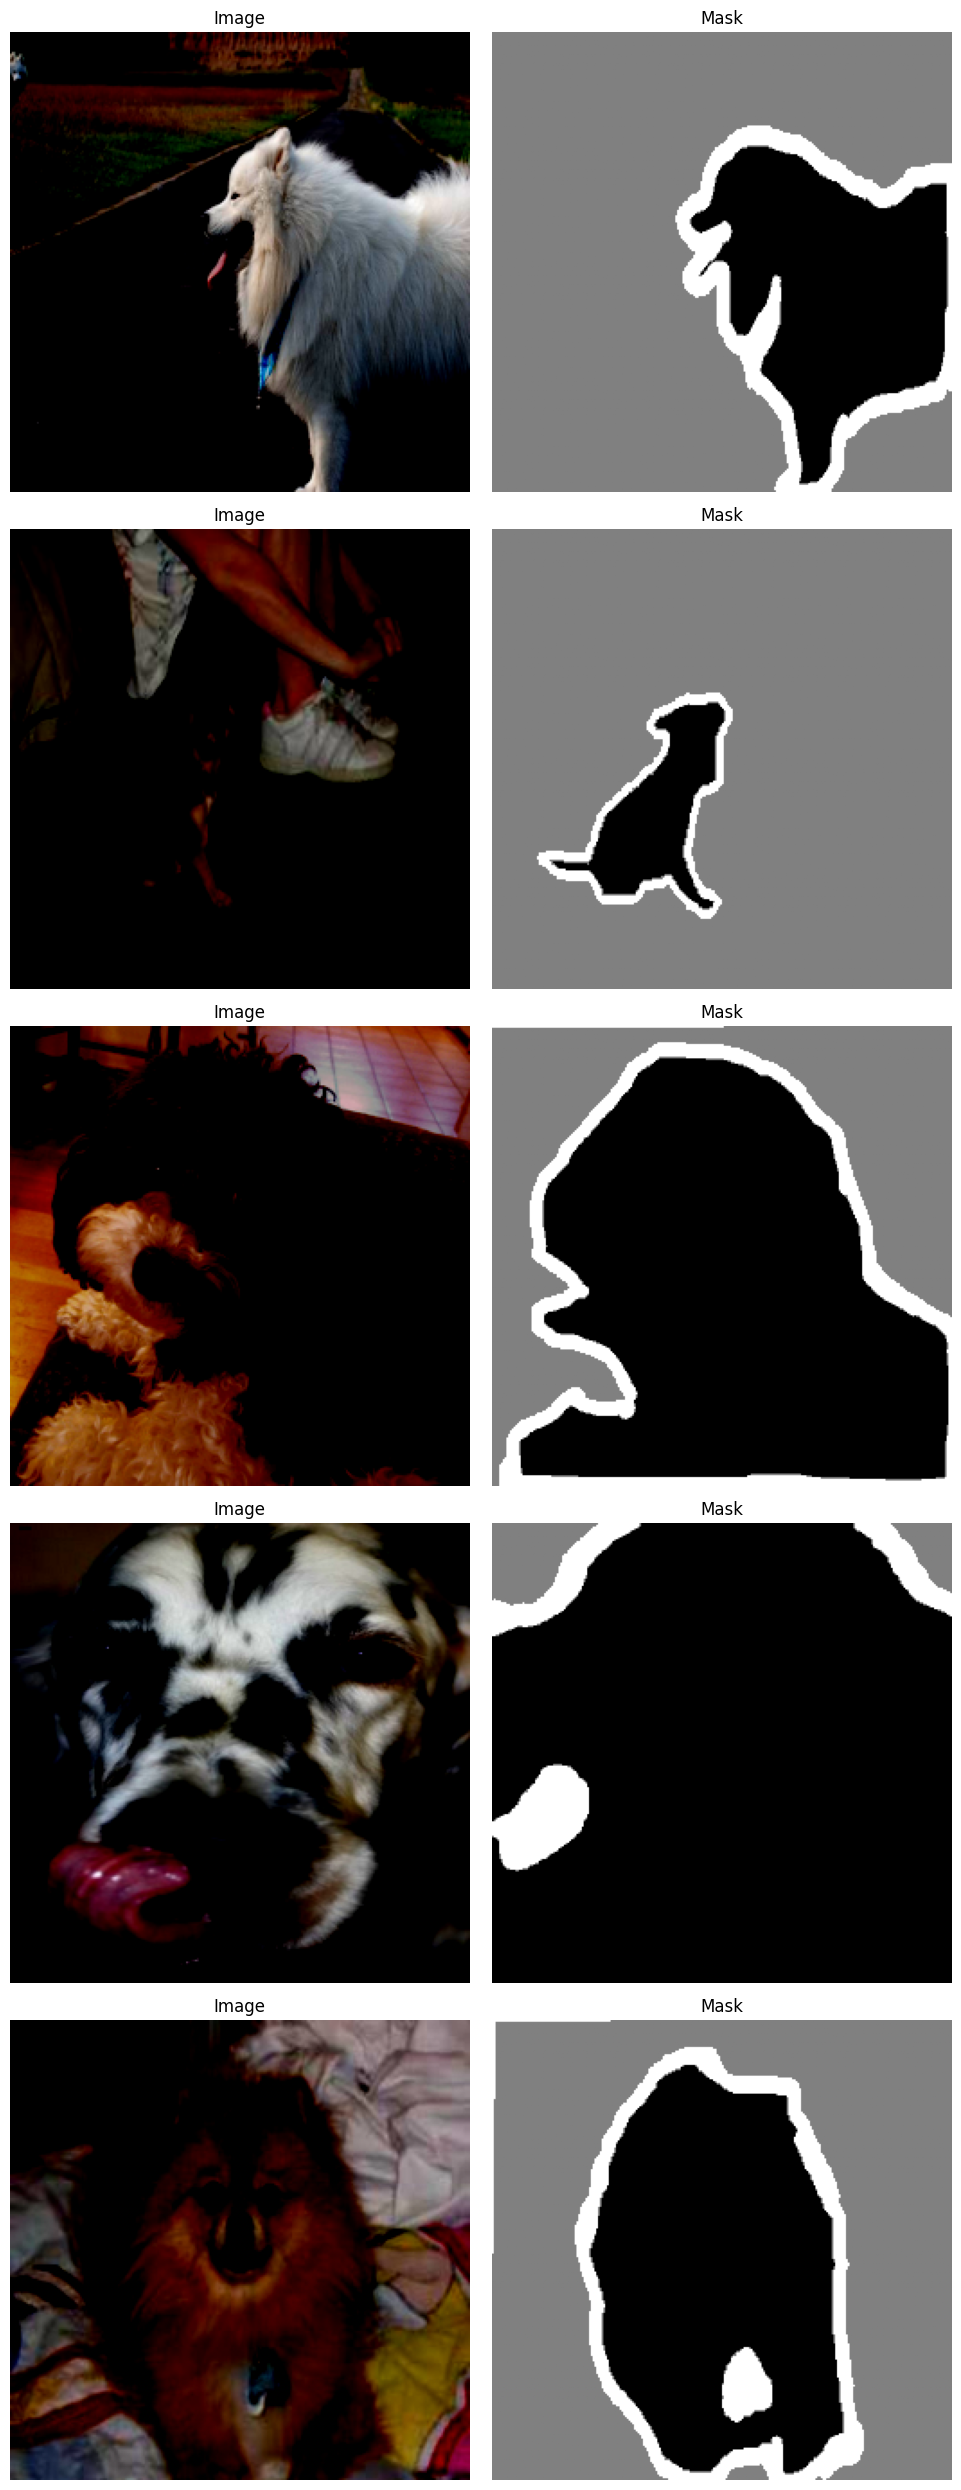

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_samples(dataset, num_samples=3):
  """Shows random samples from the dataset, including images and their masks."""
  fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 5))
  for i in range(num_samples):
    idx = np.random.randint(len(dataset))
    image, mask = dataset[idx]

    # adjust dimensions for plotting
    image = image.permute(1, 2, 0).numpy()
    mask = mask.squeeze().numpy()

    axes[i, 0].imshow(image)
    axes[i, 0].set_title("Image")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(mask, cmap='gray') # grayscale for masks
    axes[i, 1].set_title("Mask")
    axes[i, 1].axis("off")
  plt.tight_layout()
  plt.show()

show_samples(train_dataset, num_samples=5)

# Train

In [ ]:
def iou_per_class(y_true, y_pred,num_classes):
    iou_per_c = []
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    for i in range(num_classes):
        class_true = (y_true == i)
        class_pred = (y_pred == i)
        intersection = (class_true & class_pred).sum()
        union = (class_true | class_pred).sum()
        if union == 0:
            # This class does not exist on this image, skip
            continue
        iou_score = intersection / union
        iou_per_c.append(iou_score)

    return torch.tensor(iou_per_c)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SETR(
    img_size = 256,
    patch_size = 16,
    embed_size = 1024,
    conv_channels = 64,
    num_classes = 3,
    in_channels = 3,
    num_heads = 4,
    num_layers = 6,
    ff_expansion = 4,
    vit_dout = 0.1,

).to(device)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()
epochs = 20

In [ ]:
from tqdm import tqdm
all_train_losses = []
all_val_losses = []
all_iou = []
best_val_loss = float('inf')
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    val_loss = 0.0
    iou = 0.0
    for batch in tqdm(train_loader):
        image, mask = batch
        image, mask = image.to(device), mask.to(device).squeeze().to(torch.long)
        mask_pred = model(image)
        loss = loss_fn(mask_pred, mask)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    all_train_losses.append(train_loss / len(train_loader))
    model.eval()
    with torch.no_grad():
        for batch in tqdm(val_loader):
            image, mask = batch
            image, mask = image.to(device), mask.to(device).squeeze().to(torch.long)
            mask_pred = model(image)
            loss = loss_fn(mask_pred, mask)
            val_loss += loss.item()
            iou += torch.mean(iou_per_class(mask, mask_pred.argmax(1),3))

    avg_val_loss = val_loss / len(val_loader)
    avg_iou = iou / len(val_loader)
    all_iou.append(avg_iou)
    all_val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss / len(train_loader)}, Val Loss: {avg_val_loss}, VAl IOU: {avg_iou}")
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            }, f"best_model.pt")
        print(f"New best model saved with val loss: {best_val_loss:.6f}")


100%|██████████| 115/115 [01:09<00:00,  1.66it/s]


Epoch 1/20, Train Loss: 0.7476540757262189, Val Loss: 0.6909239535746368, VAl IOU: 0.400087833404541
New best model saved with val loss: 0.690924


100%|██████████| 115/115 [01:09<00:00,  1.66it/s]


Epoch 2/20, Train Loss: 0.6409820613653764, Val Loss: 0.6344270504039267, VAl IOU: 0.4383963346481323
New best model saved with val loss: 0.634427


100%|██████████| 115/115 [01:09<00:00,  1.65it/s]


Epoch 3/20, Train Loss: 0.5808150050432785, Val Loss: 0.5992343578649604, VAl IOU: 0.46613776683807373
New best model saved with val loss: 0.599234


100%|██████████| 115/115 [01:09<00:00,  1.66it/s]


Epoch 4/20, Train Loss: 0.5248731449894283, Val Loss: 0.5933039354241413, VAl IOU: 0.48621097207069397
New best model saved with val loss: 0.593304


100%|██████████| 115/115 [01:09<00:00,  1.66it/s]


Epoch 5/20, Train Loss: 0.4583904831305794, Val Loss: 0.6021944686122562, VAl IOU: 0.4977901875972748


100%|██████████| 115/115 [01:09<00:00,  1.66it/s]


Epoch 6/20, Train Loss: 0.38942503929138184, Val Loss: 0.6126222646754721, VAl IOU: 0.5140214562416077


100%|██████████| 115/115 [01:09<00:00,  1.66it/s]


Epoch 7/20, Train Loss: 0.32912926388823466, Val Loss: 0.6482848607975503, VAl IOU: 0.5120560526847839


 10%|█         | 12/115 [00:18<02:40,  1.56s/it]


KeyboardInterrupt: 

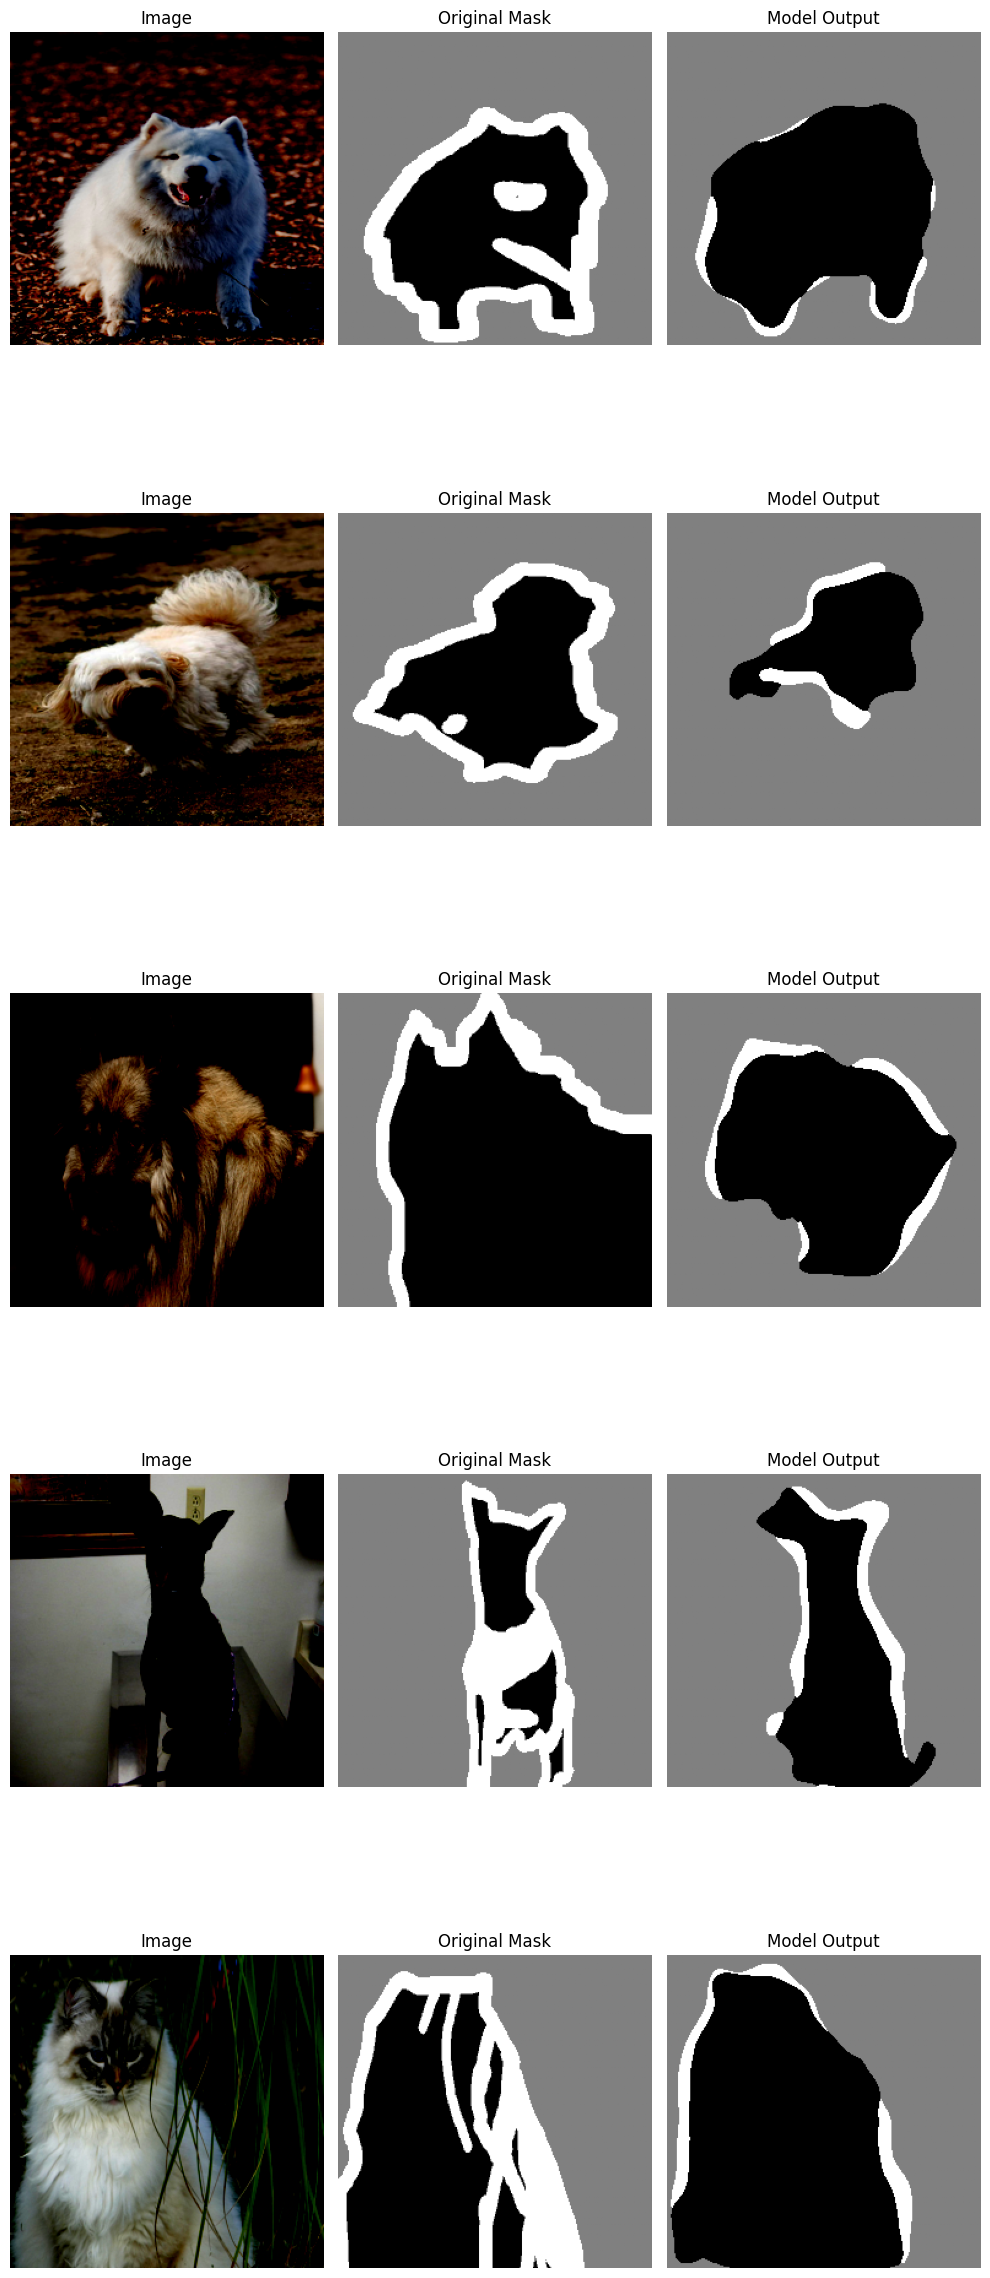

In [ ]:

def show_predictions(model, dataset, num_samples=3):
  """Shows random samples from the dataset, their masks, and the model's predictions."""
  model.eval()
  fig, axes = plt.subplots(num_samples, 3, figsize=(10, num_samples * 5))
  with torch.no_grad():
    for i in range(num_samples):
      idx = np.random.randint(len(dataset))
      image, mask = dataset[idx]
      image_tensor = image.unsqueeze(0).to(device) # Add batch dimension and move to device
      mask_pred = model(image_tensor).argmax(1).squeeze().cpu().numpy() # Get prediction, remove batch, move to cpu, to numpy

      # adjust dimensions for plotting
      image = image.permute(1, 2, 0).numpy()
      mask = mask.squeeze().numpy()

      axes[i, 0].imshow(image)
      axes[i, 0].set_title("Image")
      axes[i, 0].axis("off")

      axes[i, 1].imshow(mask, cmap='gray') # grayscale for masks
      axes[i, 1].set_title("Original Mask")
      axes[i, 1].axis("off")

      axes[i, 2].imshow(mask_pred, cmap='gray') # grayscale for predictions
      axes[i, 2].set_title("Model Output")
      axes[i, 2].axis("off")
  plt.tight_layout()
  plt.show()

# Load the best model
checkpoint = torch.load("best_model.pt")
model.load_state_dict(checkpoint['model_state_dict'])

# Show predictions on validation dataset
show_predictions(model, val_dataset, num_samples=5)
